# GA-LLAMEA Metrics Run Visualization

Visualization of results from `../results/GA-LLAMEA-Metrics_20260206_015451`.\n
This includes:
- Convergence Plots
- CEG Plots
- Boxplots (Fitness with and without Hue)
- Fitness Tables
- Behavior Metrics


In [1]:
from iohblade.loggers import ExperimentLogger
from iohblade.plots import plot_convergence, plot_experiment_CEG, plot_boxplot_fitness_hue, plot_boxplot_fitness, fitness_table
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Results
logger = ExperimentLogger('../results/GA-LLAMEA-Metrics_20260206_015451', True)
methods, problems = logger.get_methods_problems()
print("Methods:", methods)
print("Problems:", problems)

c:\Users\Kukoy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Methods: ['GA-LLAMEA-2', 'GA-LLAMEA-1', 'GA-LLAMEA-0']
Problems: ['MA_BBOB']


## 1. Convergence Plots
Comparing the convergence of methods across the budget.

GA-LLAMEA Metrics Convergence


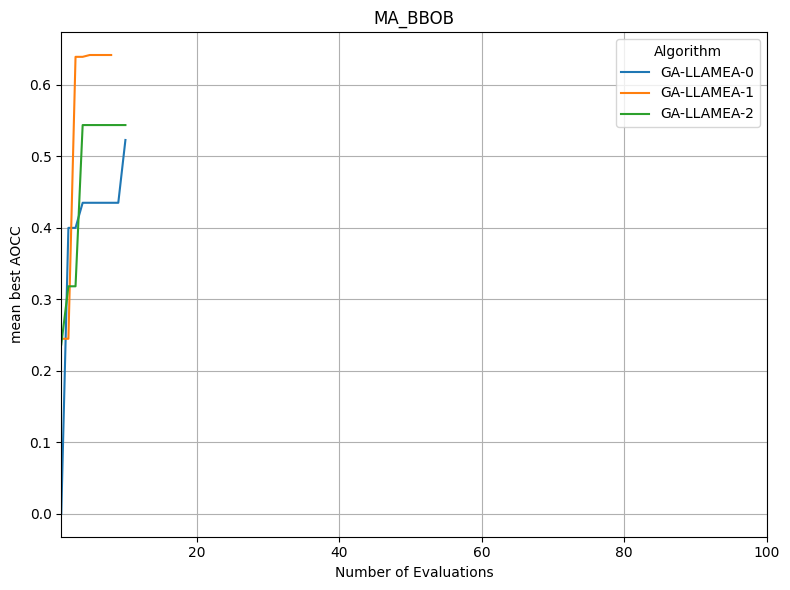

In [2]:
print("GA-LLAMEA Metrics Convergence")
try:
    plot_convergence(logger, metric="AOCC", save=False, budget=100)
    plt.show()
except Exception as e:
    print(f"Error plotting GA-LLAMEA Metrics convergence: {e}")

## 2. CEG Plots (Constrained Expected Generation)
Visualize the CEG metric for both experiments.

GA-LLAMEA Metrics CEG


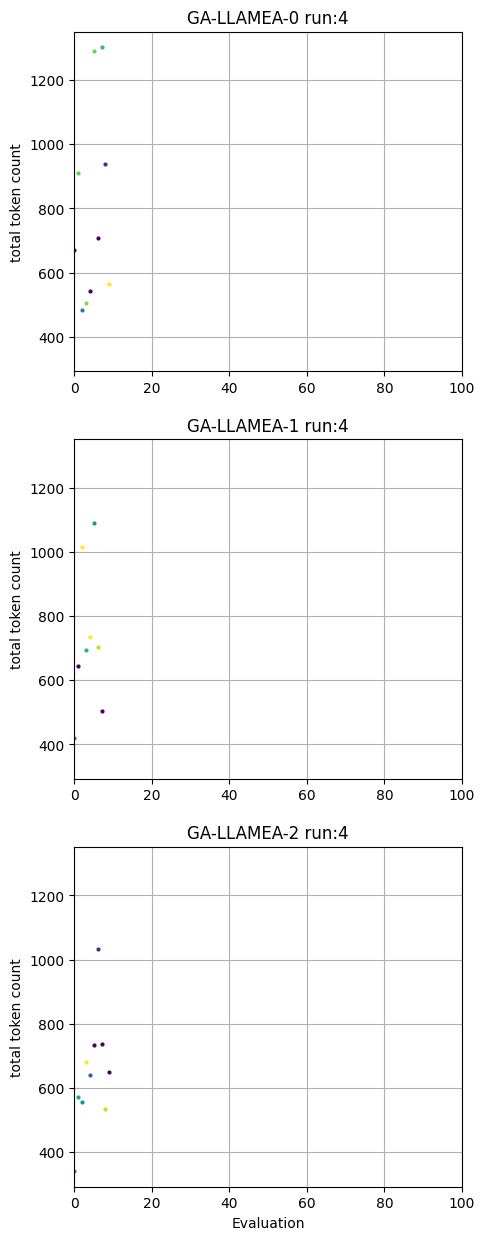

In [3]:
print("GA-LLAMEA Metrics CEG")
try:
    plot_experiment_CEG(logger, save=False, budget=100, max_seeds=5)
    plt.show()
except Exception as e:
    print(f"Error plotting GA-LLAMEA Metrics CEG: {e}")

## 3. Boxplots (Fitness)
Distribution of fitness values found by different methods.

GA-LLAMEA Metrics Fitness Boxplot


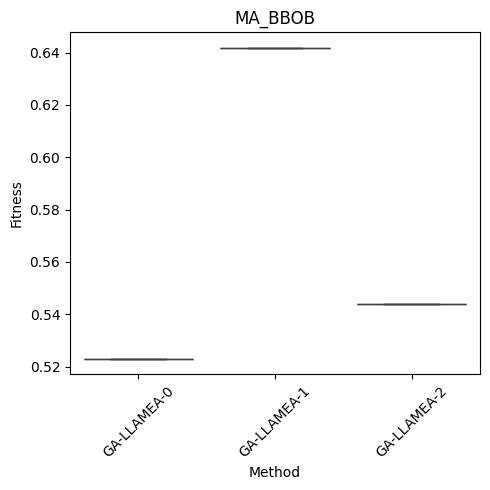

In [4]:
print("GA-LLAMEA Metrics Fitness Boxplot")
try:
    plot_boxplot_fitness(logger)
    plt.show()
except Exception as e:
    print(f"Error plotting GA-LLAMEA Metrics boxplot: {e}")

## 4. Fitness Distribution with Hue
Visualizing fitness distribution with distinction.

In [5]:
print("GA-LLAMEA Metrics Fitness Boxplot (Hue)")
try:
    plot_boxplot_fitness_hue(logger)
    plt.show()
except Exception as e:
    print(f"Error plotting GA-LLAMEA Metrics hue boxplot: {e}")

GA-LLAMEA Metrics Fitness Boxplot (Hue)


## 5. Fitness Tables
Tabular summary of fitness statistics.

In [6]:
print("GA-LLAMEA Metrics Fitness Table")
try:
    print(fitness_table(logger))
except Exception as e:
    print(f"Error generating GA-LLAMEA Metrics fitness table: {e}")

GA-LLAMEA Metrics Fitness Table
                         MA_BBOB
GA-LLAMEA-0  0.52 ± 0.00 (p=nan)
GA-LLAMEA-1  0.64 ± 0.00 (p=nan)
GA-LLAMEA-2  0.54 ± 0.00 (p=nan)


c:\Users\Kukoy\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Kukoy\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1114: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


## 6. Behavior Metrics
Analysis of behavioral features (convergence, success rates, etc).

In [7]:
from iohblade.behaviour_metrics import compute_behavior_metrics, average_convergence_rate, improvement_statistics, longest_no_improvement_streak, last_improvement_fraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np

def safe_compute_metrics(df):
    # Ensure required columns exist
    if 'raw_y' not in df.columns and 'fitness' in df.columns:
        df['raw_y'] = df['fitness']
    if 'evaluations' not in df.columns:
        df = df.reset_index(drop=True)
        df['evaluations'] = df.index + 1

    # Check for x columns
    x_cols = [c for c in df.columns if c.startswith("x")]
    
    # If no x columns but we have code, project code to latent space
    if not x_cols and 'code' in df.columns:
        try:
            # 1. Vectorize code
            # Use TfidfVectorizer to capture semantic similarity of keywords/structure
            vectorizer = TfidfVectorizer(max_features=1000)
            # Ensure string type and handle missing
            code_data = df['code'].fillna('').astype(str)
            if len(code_data) > 1:
                X_tfidf = vectorizer.fit_transform(code_data)
                
                # 2. Reduce dimensionality (Project to "Coordinate Space")
                # Use 10 dimensions or less if fewer samples. SVD requires n_components < n_samples
                n_components = min(10, len(df) - 1, X_tfidf.shape[1] - 1)
                if n_components > 1:
                    svd = TruncatedSVD(n_components=n_components, random_state=42)
                    X_reduced = svd.fit_transform(X_tfidf)
                    
                    # 3. Assign as x coordinates
                    for i in range(n_components):
                        df[f'x{i}'] = X_reduced[:, i]
                    
                    x_cols = [f'x{i}' for i in range(n_components)]
        except Exception as e:
            # print(f"Warning: Code projection failed: {e}")
            pass

    if x_cols:
        # Some metrics might fail if bounds are expected but random X has arbitrary range
        # We let compute_behavior_metrics handle defaults (it infers bounds from data min/max if not provided)
        return compute_behavior_metrics(df)
    
    # Compute limit metrics (only y-based) if projection failed or no code
    avg_imp, success_rate = improvement_statistics(df)
    metrics = {
        "average_convergence_rate": average_convergence_rate(df),
        "avg_improvement": avg_imp,
        "success_rate": success_rate,
        "longest_no_improvement_streak": longest_no_improvement_streak(df),
        "last_improvement_fraction": last_improvement_fraction(df),
        "avg_nearest_neighbor_distance": float("nan"),
        "dispersion": float("nan"),
        "avg_exploration_pct": float("nan"),
        "avg_distance_to_best": float("nan"),
        "intensification_ratio": float("nan"),
        "avg_exploitation_pct": float("nan"),
    }
    return metrics

def display_metrics(logger, name):
    print(f"--- {name} Behavior Metrics ---")
    methods, problems = logger.get_methods_problems()
    all_metrics = []

    for problem in problems:
        try:
            df_problem = logger.get_problem_data(problem)
            # Group by method and seed (run)
            grouped = df_problem.groupby(["method_name", "seed"])
            
            for (method, seed), gdf in grouped:
                gdf = gdf.copy()
                m = safe_compute_metrics(gdf)
                m['method'] = method
                m['problem'] = problem
                m['seed'] = seed
                all_metrics.append(m)
        except Exception as e:
            # print(f"Error processing problem {problem}: {e}")
            pass

    if not all_metrics:
        print("No metrics computed.")
        return

    df_metrics = pd.DataFrame(all_metrics)
    # Aggregate by method
    df_agg = df_metrics.groupby("method").mean(numeric_only=True)
    return df_agg

In [8]:
print("GA-LLAMEA Metrics Behavior Metrics Table")
try:
    df_mabbob_metrics = display_metrics(logger, "GA-LLAMEA Metrics")
    if df_mabbob_metrics is not None:
        display(df_mabbob_metrics)
except Exception as e:
    print(f"Error calculating GA-LLAMEA Metrics metrics: {e}")

GA-LLAMEA Metrics Behavior Metrics Table
--- GA-LLAMEA Metrics Behavior Metrics ---


,avg_nearest_neighbor_distance,dispersion,avg_exploration_pct,avg_distance_to_best,intensification_ratio,avg_exploitation_pct,average_convergence_rate,avg_improvement,success_rate,longest_no_improvement_streak,last_improvement_fraction,seed
method,,,,,,,,,,,,
GA-LLAMEA-0,0.752116,12.974358,6.448375,0.811851,1.000,93.551625,1.000000,0.000000,0.000000,9.0,1.000000,4.0
GA-LLAMEA-1,1.027904,12.135684,7.242917,0.541770,0.875,92.757083,0.007097,0.244854,0.142857,6.0,0.857143,4.0
GA-LLAMEA-2,0.952576,12.543775,6.487882,0.581818,1.000,93.512118,0.021391,0.118389,0.222222,4.0,0.444444,4.0
